Reading data file... Done.
Data preprocessing... Done.
Streaming data for copula learning and label propagation...
Copula calibration 0
Label propagation 0
Copula calibration 1
Label propagation 1
Copula calibration 2
Label propagation 2
Copula calibration 3
Label propagation 3
Copula calibration 4
Label propagation 4
Copula calibration 5
Label propagation 5
Copula calibration 6
Label propagation 6
Copula calibration 7
Label propagation 7
Copula calibration 8
Label propagation 8
Copula calibration 9
Label propagation 9
Copula calibration 10
Label propagation 10
Copula calibration 11
Label propagation 11
Copula calibration 12
Label propagation 12
Copula calibration 13
Label propagation 13
Copula calibration 14
Label propagation 14
Copula calibration 15
Label propagation 15
Copula calibration 16
Label propagation 16
Copula calibration 17
Label propagation 17
Copula calibration 18
Label propagation 18
Copula calibration 19
Label propagation 19
Copula calibration 20
Label propagation 20
Do

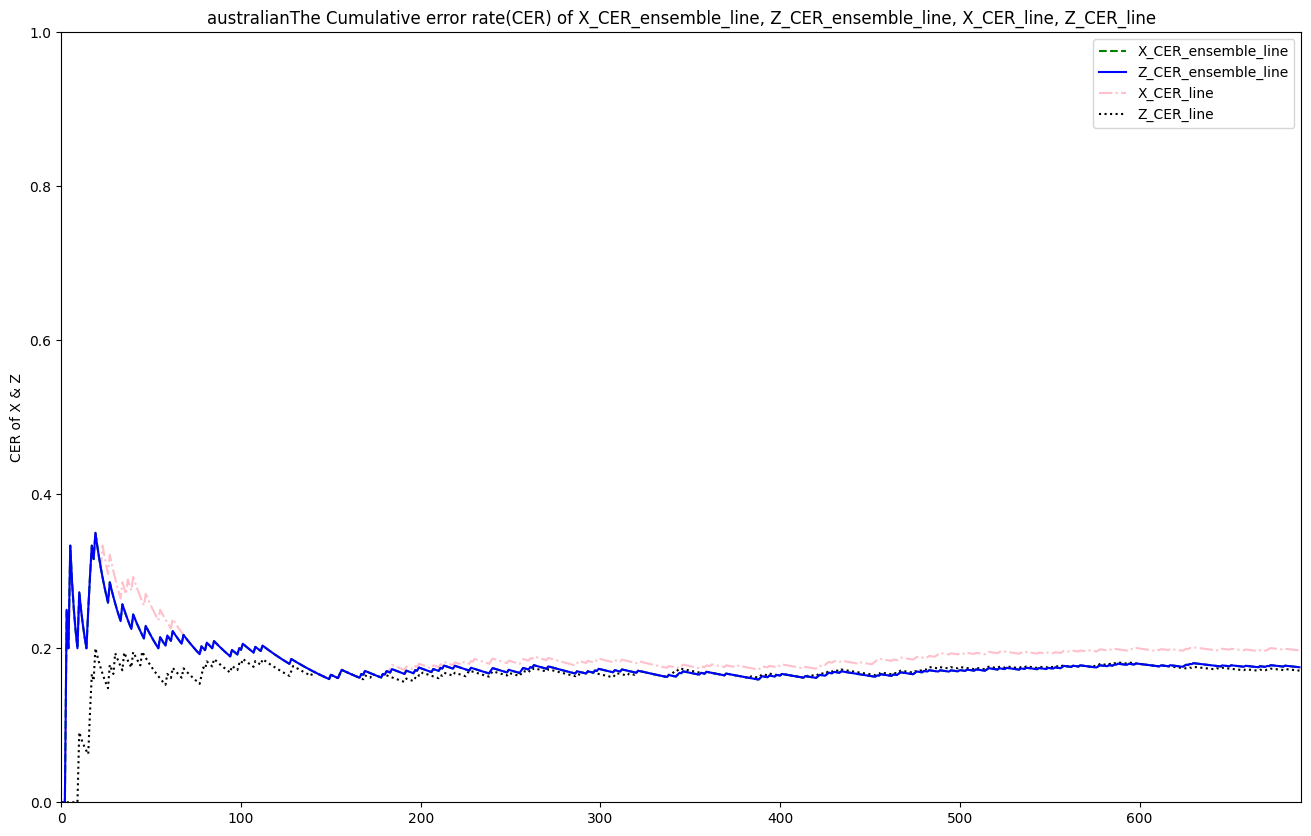

Streaming data for label prediction...
	with original data only...
	with latent representations...
Done.


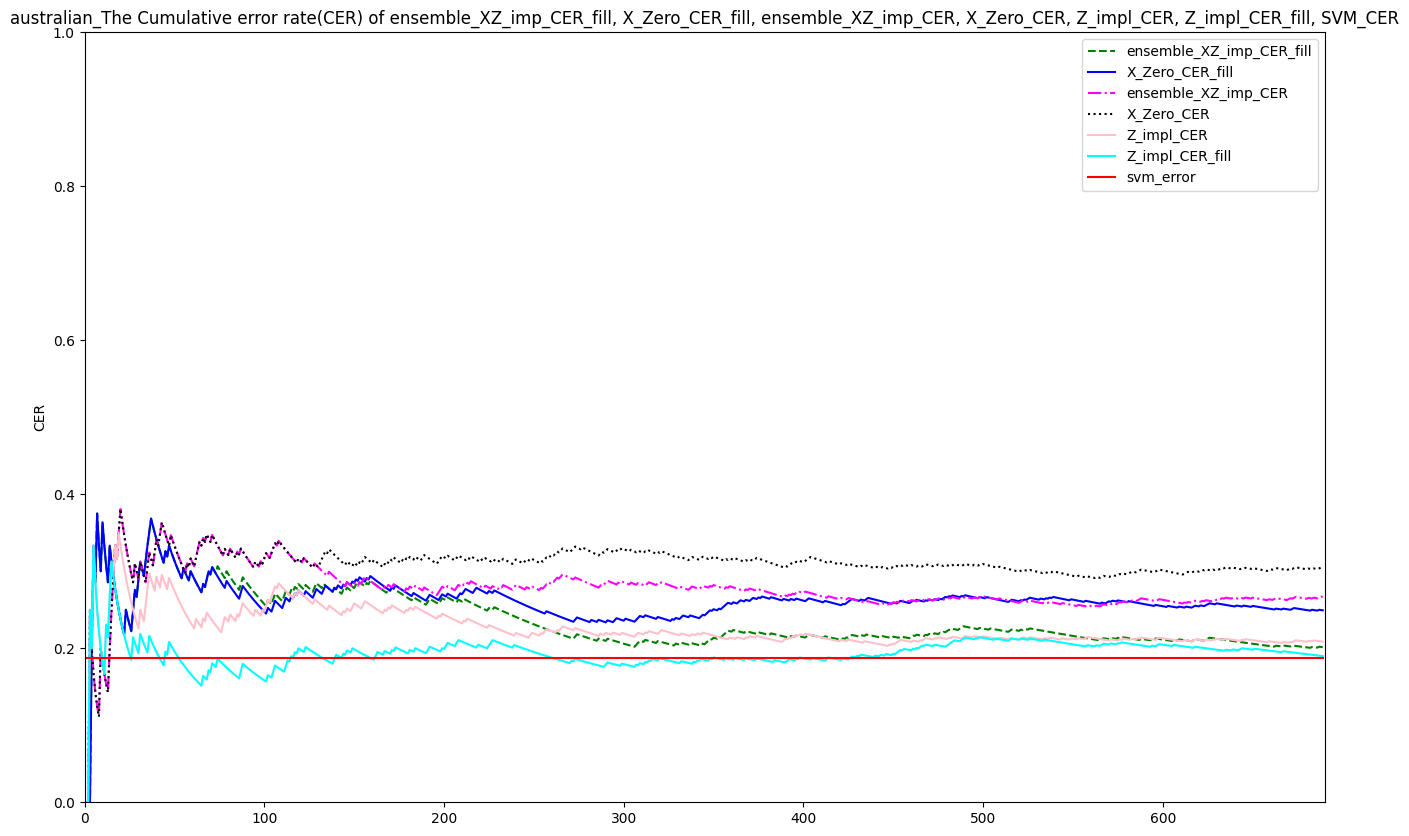

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import math
import random
from time import time
sys.path.append("..")
from sklearn.svm import SVC
from evaluation.helpers import *
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from onlinelearning.ensemble import *
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from onlinelearning.online_learning import *
from semi_supervised.semiSupervised import *
from sklearn.preprocessing import StandardScaler
from em.online_expectation_maximization import OnlineExpectationMaximization

if __name__ == '__main__':
    # dataset: wpbc; ionosphere; wdbc; australian; credit; wbc; diabetes; dna; german; splice; kr_vs_kp; magic04; a8a; stream
    dataset = "australian"

    print("Reading data file...", end=" ")
    # getting hyperparameter
    contribute_error_rate, window_size_denominator, batch_size_denominator, decay_coef_change, decay_choice, shuffle =\
        get_cap_hyperparameter(dataset)
    MASK_NUM = 1
    if dataset == "Stream1":
        X = pd.read_csv("../dataset/MaskData/" + dataset + "/X.txt", sep = " ", header = None)
    else:
        X = pd.read_csv("../dataset/MaskData/" + dataset + "/X_process.txt", sep = " " , header = None)
    if dataset == "a8a":
        X = abs(X)
    Y_label = pd.read_csv("../dataset/DataLabel/" + dataset + "/Y_label.txt", sep = ' ', header = None)
    print("Done.")

    print("Data preprocessing...", end=" ")
    # ionosphere, diabetes, credit
    if (dataset == "magic04") & (shuffle == True):
        shufflenum = shuffle_dataset_1(Y_label)

    Y_label_masked = random.sample(range(1, Y_label.shape[0]), int(Y_label.shape[0] * 0.5)) # Hard coded 50% of masked label
    Y_label_masked.sort()
    Y_label_masked = np.array(Y_label_masked)
    X_masked = mask_types(X, MASK_NUM, seed = 1)    # For each row, group features by two and mask one randomly
    X = X.values
    Y_label = Y_label.values

    if (dataset == "magic04") & (shuffle == True):
        X = X[shufflenum]
        Y_label = Y_label[shufflenum]

    all_cont_indices = get_cont_indices(X_masked)   # array[bool]: Get indices of features that are considered continuous (at least 14[hardcoded] unique values)
    all_ord_indices  = ~all_cont_indices            # array[bool]: Get indices of features that are considered discrete

    n = X_masked.shape[0]
    feat = X_masked.shape[1]
    Y_label = Y_label.flatten()
    Y_label_masked = Y_label_masked.flatten()       # array[int]: Contains mask indices
    print("Done.")

    # setting hyperparameter
    max_iter = batch_size_denominator * 2           # australian: 10*2
    BATCH_SIZE = math.ceil(n / batch_size_denominator)
    WINDOW_SIZE = math.ceil(n / window_size_denominator)    # australian: 2
    NUM_ORD_UPDATES = 1
    batch_c = 8

    # start online copula imputation
    oem = OnlineExpectationMaximization(all_cont_indices, all_ord_indices, window_size=WINDOW_SIZE)
    j = 0
    X_imp    = np.empty(X_masked.shape)
    Z_imp    = np.empty(X_masked.shape)
    X_masked = np.array(X_masked)
    Y_label_fill_x = np.empty(Y_label.shape)
    Y_label_fill_z = np.empty(Y_label.shape)
    Y_label_fill_x_ensemble = np.empty(Y_label.shape)
    Y_label_fill_z_ensemble = np.empty(Y_label.shape)

    clf1 = LinearSVC(random_state=0, tol=1e-5)
    clf2 = LinearSVC(random_state=0, tol=1e-5)
    clf_x = LinearSVC(random_state=0, tol=1e-5)
    clf_z = LinearSVC(random_state=0, tol=1e-5)

    print("Streaming data for copula learning and label propagation...")
    while j <= max_iter:    # Hardcoded to two run on the batch
        start = (j * BATCH_SIZE) % n
        end   = ((j + 1) * BATCH_SIZE) % n
        if end < start:
            indices = np.concatenate((np.arange(end), np.arange(start, n, 1))) # 生成某个范围或区间对应的数组
        else:
            indices = np.arange(start, end, 1)
        if decay_coef_change == 1:                      # Hardcoded as 0 in the helpers.py script right now
            this_decay_coef = batch_c / (j + batch_c)
        else:
            this_decay_coef = 0.5

        print("Copula calibration", j)
        # do one step on the batch (= incoming stream of data)
        Z_imp[indices, :], X_imp[indices, :] = oem.partial_fit_and_predict(X_masked[indices, :], max_workers = 1, decay_coef = this_decay_coef) # Does a step of EM (update sigma, predict new z [ordinal and missing]). Predict missing original data.

        if start == 0:
            train_x, label_train_x, initial_label_x = X_imp[indices, :], Y_label[indices, ], Y_label_masked[(Y_label_masked > start) & (Y_label_masked < end) ]
            train_z, label_train_z, initial_label_z = Z_imp[indices, :], Y_label[indices, ], Y_label_masked[(Y_label_masked > start) & (Y_label_masked < end) ]
        elif end == 0:
            train_x, label_train_x, initial_label_x = X_imp[indices, :], Y_label[indices, ], Y_label_masked[(Y_label_masked > start) & (Y_label_masked < ((j + 1) * BATCH_SIZE))] % start   #??? adaptative translation of indices to 0
            train_z, label_train_z, initial_label_z = Z_imp[indices, :], Y_label[indices, ], Y_label_masked[(Y_label_masked > start) & (Y_label_masked < ((j + 1) * BATCH_SIZE))] % start   #??? adaptative translation of indices to 0
        elif end < start:
            initial_label_x = Y_label_masked[(Y_label_masked > start)]
            initial_label_x = initial_label_x.tolist()
            initial_label_x.extend(Y_label_masked[(Y_label_masked < end)])
            initial_label_x = np.array(initial_label_x)
            np.sort(initial_label_x)
            initial_label_x = initial_label_x % len(indices)    #??? adaptative translation of indices to start at 0. BUT incorrect implementation
            train_x, label_train_x = X_imp[indices, :], Y_label[indices,]

            initial_label_z = Y_label_masked[(Y_label_masked > start)]
            initial_label_z = initial_label_z.tolist()
            initial_label_z.extend(Y_label_masked[(Y_label_masked < end)])
            initial_label_z = np.array(initial_label_z)
            np.sort(initial_label_z)
            initial_label_z = initial_label_z % len(indices)    #??? adaptative translation of indices to start at 0. BUT incorrect implementation
            train_z, label_train_z = Z_imp[indices, :], Y_label[indices,]
        else:
            train_x, label_train_x, initial_label_x = X_imp[indices, : ], Y_label[indices, ], Y_label_masked[(Y_label_masked > start) & (Y_label_masked < end) ] % start    #??? adaptative translation of indices to start at 0
            train_z, label_train_z, initial_label_z = Z_imp[indices, : ], Y_label[indices, ], Y_label_masked[(Y_label_masked > start) & (Y_label_masked < end) ] % start    #??? adaptative translation of indices to start at 0

        print("Label propagation", j)
        # preprocess geometric structure (Density Peaks)
        percent = 5

        nneigh_x = DensityPeaks(train_x, percent)   # n x 1 matrix: i-th row contains value j. j is the index of the "neighbor" of i. j -> i?
        nneigh_z = DensityPeaks(train_z, percent)

        # fit and train classifiers in an ensemble way
        predict_label_train_x_ensemble = SSC_DensityPeaks_SVC_ensemble(train_x, label_train_x, train_z, label_train_z, initial_label_x, nneigh_x, nneigh_z, clf1, clf2)
        predict_label_train_z_ensemble = SSC_DensityPeaks_SVC_ensemble(train_z, label_train_z, train_x, label_train_x, initial_label_z, nneigh_z, nneigh_x, clf1, clf2)
        Y_label_fill_x_ensemble[indices, ] = predict_label_train_x_ensemble
        Y_label_fill_z_ensemble[indices, ] = predict_label_train_z_ensemble

        # fit and train classifiers individually
        predict_label_train_x = SSC_DensityPeaks_SVC(train_x, label_train_x, initial_label_x, nneigh_x, clf_x)
        Y_label_fill_x[indices,] = predict_label_train_x

        predict_label_train_z = SSC_DensityPeaks_SVC(train_z, label_train_z, initial_label_z, nneigh_z, clf_z)
        Y_label_fill_z[indices, ] = predict_label_train_z

        j += 1
    print("Done.")

    # geting and drawing the error of Semi-Supervised
    Cumulative_error_rate_semi(Y_label_fill_x_ensemble,
                               Y_label_fill_z_ensemble,
                               Y_label_fill_x,
                               Y_label_fill_z,
                               Y_label,
                               dataset)

    temp = np.ones((n, 1))
    
    X_masked = pd.DataFrame(X_masked)
    X_zeros = X_masked.fillna(value=0)
    X_input_zero = np.hstack((temp, X_zeros))
    X_input_imp = np.hstack((temp, X_imp))      # added to replace X_zeros
    if shuffle == True:
        perm = np.arange(n)
        np.random.seed(1)
        np.random.shuffle(perm)
        Y_label = Y_label[perm]
        X_input_zero = X_input_zero[perm]
        X_input_imp = X_input_imp[perm]
        Y_label_fill_x = Y_label_fill_x[perm]
        Y_label_fill_z = Y_label_fill_z[perm]

    print("Streaming data for label prediction...")
    batch = math.ceil(n / 100)

    print("\twith original data only...")
    #X_Zero_CER_fill, svm_error = generate_X_Y(n, X_input_zero, Y_label_fill_x, Y_label, decay_choice, contribute_error_rate)
    X_Zero_CER_fill, svm_error = generate_X_Y(n, X_input_imp, Y_label_fill_x, Y_label, decay_choice, contribute_error_rate)

    #X_Zero_CER = generate_Xmask(n, X_input_zero, Y_label, Y_label_masked, decay_choice, contribute_error_rate)
    X_Zero_CER = generate_Xmask(n, X_input_imp, Y_label, Y_label_masked, decay_choice, contribute_error_rate)

    #get the error of latent space
    temp_zim = np.ones((n, 1))
    X_input_z_imp = np.hstack((temp, Z_imp))
    if shuffle == True:
        perm = np.arange(n)
        np.random.seed(1)
        np.random.shuffle(perm)
        X_input_z_imp = X_input_z_imp[perm]

    print("\twith latent representations...")
    Z_impl_CER = generate_Xmask(n, X_input_z_imp, Y_label, Y_label_masked, decay_choice, contribute_error_rate)
    Z_impl_CER_fill, svm_error_z = generate_X_Y(n, X_input_z_imp, Y_label_fill_z, Y_label, decay_choice, contribute_error_rate)

    # ensemble_XZ_imp_CER_fill, lamda_array_XZ_fill = ensemble_Y(n, X_input_z_imp, X_input_zero, Y_label, Y_label_fill_x, decay_choice, contribute_error_rate)

    # ensemble_XZ_imp_CER = ensemble_Xmask(n, X_input_z_imp, X_input_zero, Y_label, Y_label_masked, decay_choice, contribute_error_rate)

    ensemble_XZ_imp_CER_fill, lamda_array_XZ_fill = ensemble_Y(n, X_input_z_imp, X_input_imp, Y_label, Y_label_fill_x, decay_choice, contribute_error_rate)

    ensemble_XZ_imp_CER = ensemble_Xmask(n, X_input_z_imp, X_input_imp, Y_label, Y_label_masked, decay_choice, contribute_error_rate)
    print("Done.")

    draw_cap_error_picture(ensemble_XZ_imp_CER_fill,
                           X_Zero_CER_fill,
                           ensemble_XZ_imp_CER,
                           X_Zero_CER,
                           Z_impl_CER,
                           Z_impl_CER_fill,
                           svm_error,
                           dataset)
